In [1]:
# Bibliotecas a utilizar 
import numpy                   as np      # Uso de álgebra lineal, funciones vectoriales
import pandas                  as pd      # Trabajar con DataFrames
import matplotlib.pyplot       as plt     # Para realizar gráficas
import seaborn                 as sns     # Otras funciones para graficar

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    as LDA  # Modelo LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # Modelo QDA
from sklearn.metrics               import accuracy_score     # Función para calcular la precisión de clasificación
from sklearn.metrics               import confusion_matrix   # Función para calcular una matriz de confusión
from scipy.optimize import minimize

sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
##################################################################
# Definimos nuestra función para calcular la distancia minima de un punto y una recta
##################################################################
def distancia_puntorecta( coeficientes, punto ):
    ##################################################################
    # Esto es un comentario
    # Lo siguiente es la cadena de documentación
    ##################################################################
    """
distancia_puntorecta
    
    Regresa la distancia mínima de un punto a una recta.
    Donde la recta se expresa como Ax + By + C = 0; y el punto (x,y) en R^2
    
    Parámetros
    --------------------
    coeficientes   - tipo flotante, lista/tupla con dimensión (3,) (obligatorio)
        coeficientes de la recta (A,B,C)
    punto          - tipo flotante, lista/tupla con dimensión (2,) (obligatorio)
        coordenadas del punto (x,y)
        
    Resultado
    --------------------
    distancia      - array tipo flotante de dimensión (1,)
    
    Ejemplo
    --------------------
    >> import numpy as np
    >> distancia_puntorecta( (3,4,0), (2,-1) )
    [1] 0.4
    >> distancia_puntorecta( (3,4,0), (3,4) )
    [2] 5.0
    """
    ##################################################################
    # Manejo de Excepciones
    ##################################################################
    if not type(coeficientes) in (tuple, list):
        raise Exception("'coeficientes' no es de tipo Tupla/Lista")
    if not type(punto) in (tuple, list):
        raise Exception("'punto' no es de tipo Tupla/Lista")
    if len(coeficientes) != 3:
        raise Exception("'coeficientes' debe ser de longitud 3")
    if len(punto) < 2:
        raise Exception("'punto' debe ser de longitud 2")
    ##################################################################
    # Codigo de la función
    ##################################################################
    A, B, C   = coeficientes   # Desempaquetamos los coeficientes 
    x, y      = punto          # Desempaquetamos el punto en R2
    distancia = np.abs( A * x + B * y + C ) / np.sqrt( A**2 + B**2 ) # Calculamos la distancia euclidiana
    return distancia

# Mostramos la documentación de la función
print( distancia_puntorecta.__doc__ )


distancia_puntorecta
    
    Regresa la distancia mínima de un punto a una recta.
    Donde la recta se expresa como Ax + By + C = 0; y el punto (x,y) en R^2
    
    Parámetros
    --------------------
    coeficientes   - tipo flotante, lista/tupla con dimensión (3,) (obligatorio)
        coeficientes de la recta (A,B,C)
    punto          - tipo flotante, lista/tupla con dimensión (2,) (obligatorio)
        coordenadas del punto (x,y)
        
    Resultado
    --------------------
    distancia      - array tipo flotante de dimensión (1,)
    
    Ejemplo
    --------------------
    >> import numpy as np
    >> distancia_puntorecta( (3,4,0), (2,-1) )
    [1] 0.4
    >> distancia_puntorecta( (3,4,0), (3,4) )
    [2] 5.0
    


In [3]:
distancia_puntorecta( (3,4,0), (2,-1) )

0.4

In [4]:
##################################################################
# Creamos una función que realice nuestra linea recta
##################################################################
def abline(b0, b1, color = "purple"):
    ##################################################################
    # Cadena de documentacion
    ##################################################################
    """Grafica una linea recta con ordenada al origen b0 y pendiente b1"""
    
    ##################################################################
    # Manejo de Excepciones
    ##################################################################
    if not type(b0) in (float, int):
        raise Exception("'b0' no es de tipo float/int")
    if not type(b1) in (float, int):
        raise Exception("'b1' no es de tipo float/int")
    
    ##################################################################
    # Codigo de la funcion
    ##################################################################
    x_vals = np.array( plt.gca().get_xlim() )             # Obtenemos los limites de nuestra grafica actual
    y_vals = b0 + b1 * x_vals                             # Calculamos los valores de Y
    plt.plot(x_vals, y_vals, linestyle='--', color=color) # Graficamos los valores X vs Y
    plt.legend()                                          # Colocamos una leyenda
    # Nota ::  Vease que esta funcion no "regresa" valor alguno
    
print(abline.__doc__)

Grafica una linea recta con ordenada al origen b0 y pendiente b1


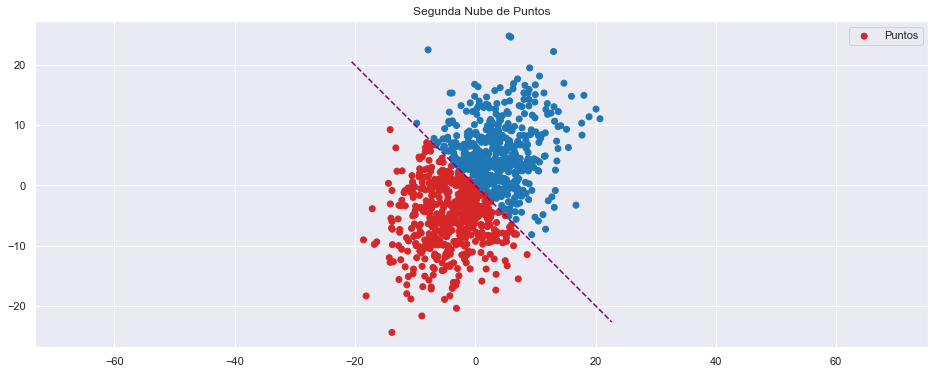

In [5]:
# Leemos datos de ejemplo
datos_2 = pd.read_csv("datos_2.csv")   # Datos con dos clases

# Graficamos nuestros puntos
fig, axs = plt.subplots( nrows = 1, ncols = 1, figsize=(16,6) )
axs.set_title("Segunda Nube de Puntos")
axs.scatter( x=datos_2["X"], y=datos_2["Y"], c=datos_2["Z"], label="Puntos")
abline(b0 = 0, b1 = -1)
axs.axis('equal')
plt.show()

La idea es encontrar los coeficientes ($\beta_0$ y $\beta_1$) que mejor separen a nuestras clases.
Para lograr nuestro cometido, como siempre debemos tener una métrica de que tan bien separa nuestras clases y maximizar dicha métrica. Sin embargo, lo más usual es definir una métrica de que tan mal separa nuestras clases y minimizar dicho error.

**Recordemos** que la recta que separa a este conjunto de puntos es la menos identidad. Es decir

$$\beta_0 = 0 \qquad \qquad \beta_1 = -1$$

Por lo cual nuestra métrica de error será algo parecido a la distancia

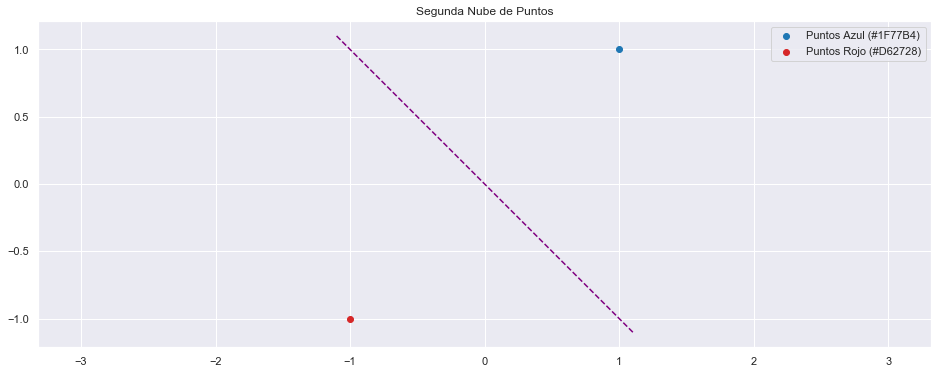

Distancia Punto Azul ::  1.414213562373095
Distancia Punto Rojo ::  -1.414213562373095


In [6]:
##################################################################
# Definimos nuestra función para calcular la distancia minima de un punto y una recta
##################################################################
def ferror( coeficientes, punto ):
    ##################################################################
    # Cadena de documentacion
    ##################################################################
    """
    Función de Error
    Devuelve la "distancia" al nuestra recta con un signo para identificar de qué lado está de la recta
    """
    ##################################################################
    # Manejo de Excepciones
    ##################################################################
    if not type(coeficientes) in (tuple, list):
        raise Exception("'coeficientes' no es de tipo Tupla/Lista")
    if not type(punto) in (tuple, list):
        raise Exception("'punto' no es de tipo Tupla/Lista")
    if len(coeficientes) != 3:
        raise Exception("'coeficientes' debe ser de longitud 3")
    if len(punto) < 2:
        raise Exception("'punto' debe ser de longitud 2")
    
    ##################################################################
    # Codigo de la funcion
    ##################################################################
    A, B, C   = coeficientes
    x, y      = punto
    distancia = ( A * x + B * y + C ) / np.sqrt( A**2 + B**2 )
    return distancia

# Graficamos nuestros puntos
fig, axs = plt.subplots( nrows = 1, ncols = 1, figsize=(16,6) )
axs.set_title("Segunda Nube de Puntos")
axs.scatter( x= 1, y= 1, c="#1F77B4", label="Puntos Azul (#1F77B4)")
axs.scatter( x=-1, y=-1, c="#D62728", label="Puntos Rojo (#D62728)")
abline(b0 = 0, b1 = -1)
axs.axis('equal')
plt.legend()
plt.show()

# Mostramos Los errores de cada punto
print( "Distancia Punto Azul :: ", ferror( (1,1,0), ( 1, 1) ) )
print( "Distancia Punto Rojo :: ", ferror( (1,1,0), (-1,-1) ) )

Por lo anterior, ambos puntos están bien clasificados, pero el punto rojo nos devuelve un resultado negativo mientras que el punto azul nos devuelve un valor positivo. Nuestra métrica inicial sería sumar dichos resultados pero cuando el punto sea azul se multiplicara por -1 para tener un resultado negativo. 

Lo que pretenderemos entonces será sumar dichos resultados y minimizar esa función (la suma de los resultados de cada punto).

Sin embargo, si utilizamos esta metrica tiene el inconveniente que para el ejemplo de arriba, hay un conjunto de posibles soluciones (todas aquellas con las misma pendiente y que esté entre ambos puntos). Por ello, podemos proponer que se eleve al cuadrado para tener una función concava y por lo tanto, tener una única solución. 

Mostraré un ejemplo de 6 datos aleatorios.

In [7]:
#####################################################################################################
# Re-Definimos nuestra función para calcular la distancia minima de un punto y una recta
# Esta es una funcion auxiliar realmente
#####################################################################################################
def ferror( coeficientes, punto_clase ):
    ##################################################################
    # Cadena de documentacion
    ##################################################################
    """
    Función de Error
    Devuelve la "distancia" al nuestra recta con un signo para identificar de qué lado está de la recta
    """
    ##################################################################
    # Manejo de Excepciones
    ##################################################################
    if not type(coeficientes) in (tuple, list):
        raise Exception("'coeficientes' no es de tipo Tupla/Lista")
    if not type(punto_clase) in (tuple, list):
        raise Exception("'punto_clase' no es de tipo Tupla/Lista")
    if len(coeficientes) != 3:
        raise Exception("'coeficientes' debe ser de longitud 3")
    if len(punto_clase) < 2:
        raise Exception("'punto' debe ser de longitud 2")
    
    ##################################################################
    # Codigo de la funcion
    ##################################################################
    A, B, C      = coeficientes
    x, y, clase  = punto_clase
    distancia    = ( A * x + B * y + C ) / np.sqrt( A**2 + B**2 )
    penalizacion = np.exp( 1e100 )
    compensacion =  1
    #############################
    # CASO :: Si eres color AZUL
    #############################
    if clase == "#1F77B4":
        if distancia < 0: # Si se equivoco
            resultado = penalizacion * ( distancia ** 2 )
        else:             # Si lo hizo correcto
            resultado = compensacion * ( distancia ** 2 )
    #############################
    # CASO :: Si es color ROJO
    #############################
    else:
        if distancia < 0: # Si lo hizo correcto
            resultado = compensacion * ( distancia ** 2 )
        else:             # Si se equivoco
            resultado = penalizacion * ( distancia ** 2 )
    return resultado
    ########################################################################################
    # Notemos que la idea es regresar un valor negativo si se clasifico de manera correcta
    # y en caso de clasificarlo de manera incorrecta, debemos regresar un valor positivo
    # esto porque la idea es siempre minimizar una funcion de error cuando el error es positivo.
    # Es decir, estamos tratando de que todos se clasifiquen correctamente
    ########################################################################################

    
    
#####################################################################################################
# AHORA DEFINIMOS UNA FUNCION QUE CALCULE EL ERROR DE UNA RECTA CON ORDENADA AL ORIGEN B0 Y PENDIENTE B1
# NOTA :: VEASE QUE ESTA FUNCION UTILIZA 'DATOS DE EJEMPLO' POR LO QUE CALCULARA EL ERROR SOBRE ESOS DATOS
# Y NO SOBRE EL CONJUNTO DE DATOS ORIGINAL
#####################################################################################################
def ferror_pendiente( betas ):
    beta0, beta1 = betas # Desempaquetamos las betas
    errores      = np.array( [ ferror( coeficientes=(-beta1, 1, -beta0), punto_clase=puntos ) for puntos in \
                             [ list(x) for x in np.array( [ datos_ejemplo.values[:,0], \
                                                            datos_ejemplo.values[:,1], \
                                                            datos_ejemplo.values[:,2] ] ).T ] ] )
    return errores

#####################################################################################################
# FINALMENTE DEFINIMOS LA FUNCION QUE QUEREMOS MINIMIZAR
# DADO UNA PENDIENTE, CALCULARA LOS ERRORES Y LOS VA A PROMEDIAR
#####################################################################################################
def funcion_optimizar( betas ):
    errores          = ferror_pendiente( betas )
    errores_promedio = np.mean( errores )
    return errores_promedio


datos_ejemplo = datos_2.sample(n=5,random_state=3)
datos_ejemplo.head()

,X,Y,Z
642,2.336277,9.685225,#1F77B4
762,0.010557,-3.043863,#D62728
909,-12.820545,-5.573570,#D62728
199,-8.280343,6.291240,#D62728
586,1.788195,13.451724,#1F77B4


Error Total Cometido ::    purple  ::  72.82725943161276
Error Total Cometido ::       red  ::  inf
Error Total Cometido ::      blue  ::  81.48236222601243
Error Total Cometido ::     green  ::  inf


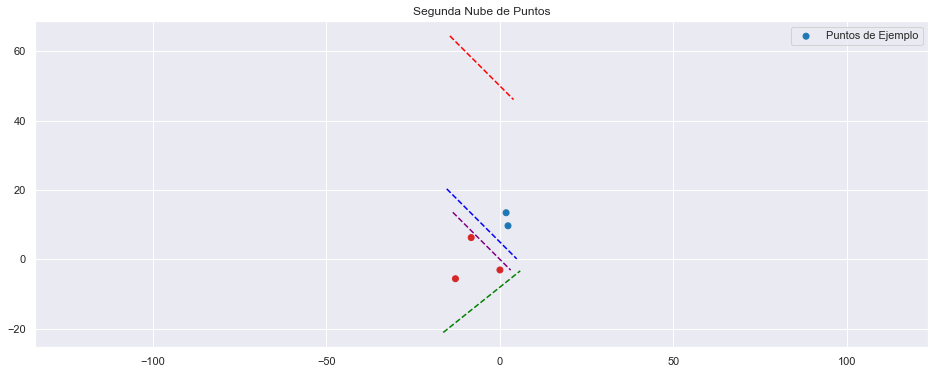

,X,Y,Z,Color,Error
0,2.336277,9.685225,#1F77B4,AZUL,24.650744
1,0.010557,-3.043863,#D62728,ROJO,32.267007
2,-12.820545,-5.573570,#D62728,ROJO,273.642309
3,-8.280343,6.291240,#D62728,ROJO,24.423776
4,1.788195,13.451724,#1F77B4,AZUL,52.427975


In [8]:
# Graficamos nuestros puntos
conjunto_betas = [ (0,-1), (50,-1), (5, -1), (-8, 0.8) ]
colores        = [ "purple", "red", "blue", "green" ]

# Graficamos algunas posibles valores de betas
fig, axs = plt.subplots( nrows = 1, ncols = 1, figsize=(16,6) )
axs.set_title("Segunda Nube de Puntos")
axs.scatter( x=datos_ejemplo["X"], y=datos_ejemplo["Y"], c=datos_ejemplo["Z"], label="Puntos de Ejemplo")
for indice in range(len(conjunto_betas)):
    betas = conjunto_betas[indice]
    abline(b0 = betas[0], b1 = betas[1], color = colores[indice] )
    print( "Error Total Cometido :: ", '{:>8}'.format(colores[indice]) , " :: ", funcion_optimizar( betas ) )
axs.axis('equal')
plt.legend()
plt.show()

pd.DataFrame( { "X"     : np.array( datos_ejemplo["X"] ),
                "Y"     : np.array( datos_ejemplo["Y"] ),
                "Z"     : np.array( datos_ejemplo["Z"] ),
                "Color" : np.array([ "AZUL" if x=="#1F77B4" else "ROJO" for x in np.array( datos_ejemplo["Z"] ) ]),
                "Error" : ferror_pendiente( conjunto_betas[2] ) } )